In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords

2018-05-08 21:19:28,207 : INFO : 'pattern' package not found; tag filters are not available for English
/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('/home/nikita/PycharmProjects/natural_language/data/test_prepocess.csv')
data.head()

,stars,text,useful,funny
0,3,The good: mini doughnuts and americano friendl...,1,0
1,3,I really like the décor of the place and the w...,0,0
2,5,"Great service, clean and great food, this plac...",1,0
3,5,This place has never failed on me! \nLate nigh...,0,0
4,2,This is a fast food spin off from Paramount Fi...,1,1


In [3]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
del data

In [4]:
%%time
n_gram_vectorizer = HashingVectorizer(
    analyzer="char",
    ngram_range=([1,3]),
    tokenizer=None,
    n_features=3000,
    preprocessor=None)

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

CPU times: user 43 µs, sys: 4 µs, total: 47 µs
Wall time: 50.8 µs


In [5]:
train_batches = [
    train_data[0:100000],
    train_data[100000:200000],
    train_data[200000:300000],
    train_data[300000:400000],
    train_data[400000:500000],
    train_data[500000:600000],
    train_data[600000:700000],
    train_data[700000:800000],
    train_data[800000:900000],
    train_data[900000:]
]

In [6]:
%%time
train_data_features = n_gram_vectorizer.fit_transform(train_batches[0].text)

CPU times: user 1min 20s, sys: 1.94 s, total: 1min 22s
Wall time: 1min 22s


In [7]:
print(len(test_data))

105234


In [8]:
%%time
logreg = logreg.fit(train_data_features, train_batches[0].stars)

CPU times: user 21min 43s, sys: 916 ms, total: 21min 44s
Wall time: 21min 44s


In [9]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy                     %s' % accuracy_score(target, predictions))
    print('explained_variance_score     %s' % explained_variance_score(target, predictions))
    print('mean_absolute_error          %s' % mean_absolute_error(target, predictions))
    print('mean_squared_error           %s' % mean_squared_error(target, predictions))
    print('mean_squared_log_error       %s' % mean_squared_log_error(target, predictions))
    print('r2_score                     %s' % r2_score(target, predictions))
    print()
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    
def plot_confusion_matrix(cm, title='Матрица ошибок', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    my_tags = pd.unique(train_batches[0].stars)
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('Исходные метки')
    plt.xlabel('Полученные метки')
    
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data.text)
    predictions = classifier.predict(data_features)
    target = data.stars
    evaluate_prediction(predictions, target)

accuracy                     0.62715
explained_variance_score     0.5595460176878673
mean_absolute_error          0.5113
mean_squared_error           0.9195
mean_squared_log_error       0.06329157308743491
r2_score                     0.5515808649021228

confusion matrix
 [[2194  227   99   94  183]
 [ 555  358  310  220  165]
 [ 198  242  740  855  359]
 [ 104   80  329 2038 2134]
 [ 121   38   99 1045 7213]]
(row=expected, col=predicted)
CPU times: user 16 s, sys: 216 ms, total: 16.2 s
Wall time: 16.8 s


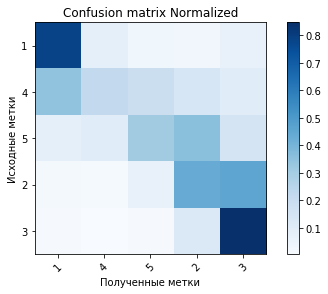

In [10]:
%%time
predict(n_gram_vectorizer, logreg, test_data[:20000])